In [1]:
#Housekeeping
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from glob import glob
import torch as torch
import cv2
from torch import nn
import torch.optim as optim
import random

In [2]:
from util import pad_img, write_to_csv, plot_metrics

In [3]:
class DrowsyDataset(Dataset):
    def __init__(self, drowsy_data, awake_data):
        self.drowsy_data = drowsy_data
        self.awake_data = awake_data
        self.images = self.create_dataset()
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = self.images[index]
        return img
    
    def create_dataset(self):
        images = []
        drowsy_length = len(os.listdir(self.drowsy_data))
        awake_length = len(os.listdir(self.awake_data))
            
        with tqdm(total=drowsy_length+awake_length, unit="img") as pbar:
          for file in os.listdir(self.drowsy_data):
            img = cv2.imread(os.path.join(self.drowsy_data, file))
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = transforms.ToTensor()(img)  
            img = pad_img(img, 60, 80)
            images.append((img, 1))       
            pbar.update()

          for file in os.listdir(self.awake_data):
            img = cv2.imread(os.path.join(self.awake_data, file))
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = transforms.ToTensor()(img)  
            img = pad_img(img, 60, 80)
            images.append((img, 0))       
            pbar.update()  
       
        return images          

In [4]:
awake = r"D:\data\awake"
drowsy = r"D:\data\drowsy"
data = DrowsyDataset(drowsy, awake)

  1%|▏         | 9/700 [00:00<00:07, 87.03img/s]

100%|██████████| 700/700 [00:02<00:00, 261.32img/s]


In [5]:
#Train test splits
length_of_dataset = len(data)
num_test = int(length_of_dataset * 0.2)
num_train = length_of_dataset - num_test
print("train_length: ", str(num_train))      
print("test_length: ", str(num_test))

from torch.utils.data import random_split
train_dataset, test_dataset = random_split(data, [num_train, num_test])

train_length:  560
test_length:  140


In [6]:
#Sanity check
print("Length of train: ", len(train_dataset))
print("Length of test: ", len(test_dataset))

img, label = train_dataset[0]

Length of train:  560
Length of test:  140


In [8]:
from torch.utils.data import DataLoader
#Turning datasets into dataloaders
batch_size = 8
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)
val_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=True)

In [9]:
#Sanity check
print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {batch_size}")

image_batch, label_batch = next(iter(train_dataloader))
print(f"Image batch shape: {image_batch.shape}")
print(f"Label batch shape: {label_batch.shape}")

Length of train dataloader: 70 batches of 8
Length of val dataloader: 18 batches of 8
Image batch shape: torch.Size([8, 3, 60, 80])
Label batch shape: torch.Size([8])


In [9]:
%reload_ext autoreload
%autoreload 2

In [11]:
def evaluate(epoch, model, test_dataloader, loss_fn, device, batch_size, progress_bar):
        model.eval() #Set model to eval mode
        epoch_loss = 0
        epoch_accuracy = 0
    
        num_batches = len(test_dataloader)
        with tqdm(total=num_test, unit="img") as progress_bar:
            for images, label in test_dataloader:
                
                images = images.to(device=device)
                label = label.to(device=device)

                with torch.autocast(device):
                    pred = model(images) #Make predictions
                    output = torch.sigmoid(pred)
                    #convert probabilities to binary predictions
                    predictions = (output > 0.5).float()
                    pred = pred.squeeze()
                    loss = loss_fn(pred.float(), label.float()) #Crossentropy loss  

                    epoch_loss += loss.item() #Add loss to running loss total

                    correct = (predictions == label).float()
                    accuracy = correct.mean()
                    epoch_accuracy += accuracy.item()
                progress_bar.update(batch_size)
                progress_bar.set_postfix(**{"Loss": loss.item(), 
                                            "Accuracy": accuracy.item()})
        #After processing all batches, average the values to get the average metrics of the epoch
        #print(vec)
        epoch_loss = epoch_loss/num_batches
        epoch_accuracy = epoch_accuracy/num_batches

        #epoch_focal = epoch_focal/num_batches
        #epoch_boundary = epoch_boundary/num_batches
        #Write metrics to CSV file
        metrics = {"Epoch": epoch, 
                    "Loss": epoch_loss, 
                    "Accuracy": epoch_accuracy}
        filename = "eval_metrics_test.csv"
        write_to_csv(filename, metrics)
        model.train()
        return epoch_loss
                
      
   





In [12]:
def train(model, epochs, train_dataloader, test_dataloader, scheduler, optimizer, loss_fn, scaler, device):
    for epoch in range(1, epochs+1):
        
        model.train() #Set model to training mode
        epoch_loss = 0
        epoch_accuracy = 0
    
        num_batches = len(train_dataloader)
        with tqdm(total=num_train, desc=f"Epoch {epoch}/{epochs}", unit="img") as progress_bar:
            for images, label in train_dataloader:
                
                images = images.to(device=device)
                label = label.to(device=device)

                with torch.autocast(device):
                    pred = model(images) #Make predictions
                    output = torch.sigmoid(pred)
                    #convert probabilities to binary predictions
                    predictions = (output > 0.5).float()
                    pred = pred.squeeze()
                    #print(pred)
                    #print(label)
                    loss = loss_fn(pred.float(), label.float()) #Crossentropy loss  

                    epoch_loss += loss.item() #Add loss to running loss total

                    correct = (predictions == label).float()
                    accuracy = correct.mean()
                    epoch_accuracy += accuracy.item()
                
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer) #Unscale so optimizer can correctly apply updates to model params
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #Clip gradients to prevent exploding gradient
                scaler.step(optimizer)
                scaler.update()

                progress_bar.update(batch_size)
                progress_bar.set_postfix(**{"Loss": loss.item(), 
                                            "Accuracy": accuracy.item()})
        #After processing all batches, average the values to get the average metrics of the epoch
        #print(vec)
        epoch_loss = epoch_loss/num_batches
        epoch_accuracy = epoch_accuracy/num_batches

        #epoch_focal = epoch_focal/num_batches
        #epoch_boundary = epoch_boundary/num_batches
        #Write metrics to CSV file
        metrics = {"Epoch": epoch, 
                    "Loss": epoch_loss, 
                    "Accuracy": epoch_accuracy}
        filename = "training_metrics_test.csv"
        write_to_csv(filename, metrics)

        #Write class IOUs to CSV file
        #iou_filename = "training_class_ious_last.csv"
        #write_class_ious(iou_filename, epoch, epoch_class_iou)
       
        #Evaluation round
        model.eval()
        print("Evaluation round")
        with tqdm(total=num_test, desc=f"Epoch {epoch}", unit="img") as progress_bar:
            loss_score = evaluate(epoch, model, test_dataloader, loss_fn, device, batch_size, progress_bar)
        scheduler.step(loss_score)
                
      
   





In [13]:
from model import ResNet50

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 100
learning_rate = 0.001

model = ResNet50(1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=3) #Reduce LR when IOU stops improving for 3 epochs
scaler = torch.cuda.amp.GradScaler(enabled=True)

In [15]:
torch.cuda.empty_cache()
import gc
gc.collect()

235

In [16]:
train(model, epochs, train_dataloader, val_dataloader, scheduler, optimizer, criterion, scaler, device)

Epoch 1/100: 100%|██████████| 560/560 [01:04<00:00,  8.63img/s, Accuracy=0.594, Loss=0.812]


Evaluation round


144img [00:03, 38.06img/s, Accuracy=1, Loss=0.484]
Epoch 2/100: 100%|██████████| 560/560 [00:21<00:00, 26.61img/s, Accuracy=0.5, Loss=0.532]  


Evaluation round


144img [00:01, 81.82img/s, Accuracy=0.5, Loss=2.73]
Epoch 3/100: 100%|██████████| 560/560 [00:15<00:00, 35.85img/s, Accuracy=0.5, Loss=0.171]   


Evaluation round


144img [00:02, 50.83img/s, Accuracy=0.75, Loss=0.438]
Epoch 4/100: 100%|██████████| 560/560 [00:23<00:00, 23.80img/s, Accuracy=0.594, Loss=0.525] 


Evaluation round


144img [00:03, 39.71img/s, Accuracy=0, Loss=3.81]
Epoch 5/100: 100%|██████████| 560/560 [00:19<00:00, 29.18img/s, Accuracy=0.531, Loss=0.118] 


Evaluation round


144img [00:03, 47.46img/s, Accuracy=0.25, Loss=1.69]
Epoch 6/100: 100%|██████████| 560/560 [00:26<00:00, 21.14img/s, Accuracy=0.625, Loss=0.0189]


Evaluation round


144img [00:03, 45.99img/s, Accuracy=0.5, Loss=17.7]
Epoch 7/100: 100%|██████████| 560/560 [00:24<00:00, 23.29img/s, Accuracy=0.625, Loss=0.00369]


Evaluation round


144img [00:03, 44.27img/s, Accuracy=0.5, Loss=0.657]
Epoch 8/100: 100%|██████████| 560/560 [00:25<00:00, 21.98img/s, Accuracy=0.531, Loss=0.00848]


Evaluation round


144img [00:02, 62.36img/s, Accuracy=0.5, Loss=0.0372]
Epoch 9/100: 100%|██████████| 560/560 [00:24<00:00, 22.99img/s, Accuracy=0.5, Loss=0.000481]  


Evaluation round


144img [00:03, 44.80img/s, Accuracy=0.5, Loss=3.97]
Epoch 10/100: 100%|██████████| 560/560 [00:23<00:00, 23.83img/s, Accuracy=0.5, Loss=0.0373]    


Evaluation round


144img [00:02, 56.30img/s, Accuracy=0.5, Loss=3.32]
Epoch 11/100: 100%|██████████| 560/560 [00:23<00:00, 23.73img/s, Accuracy=0.5, Loss=0.00102]   


Evaluation round


144img [00:05, 24.39img/s, Accuracy=1, Loss=0.000357]
Epoch 12/100: 100%|██████████| 560/560 [00:26<00:00, 21.13img/s, Accuracy=0.5, Loss=0.842]     


Evaluation round


144img [00:04, 30.53img/s, Accuracy=0.5, Loss=19.1]
Epoch 13/100: 100%|██████████| 560/560 [00:30<00:00, 18.29img/s, Accuracy=0.5, Loss=0.597]     


Evaluation round


144img [00:03, 45.67img/s, Accuracy=0.5, Loss=3.7]
Epoch 14/100: 100%|██████████| 560/560 [00:33<00:00, 16.75img/s, Accuracy=0.562, Loss=0.429]  


Evaluation round


144img [00:04, 31.09img/s, Accuracy=0.5, Loss=2.27]
Epoch 15/100: 100%|██████████| 560/560 [00:36<00:00, 15.27img/s, Accuracy=0.531, Loss=0.0218]  


Evaluation round


144img [00:04, 30.46img/s, Accuracy=0.5, Loss=2.13]
Epoch 16/100: 100%|██████████| 560/560 [00:37<00:00, 15.10img/s, Accuracy=0.625, Loss=0.00262] 


Evaluation round


144img [00:04, 31.72img/s, Accuracy=0.5, Loss=0.00332]
Epoch 17/100: 100%|██████████| 560/560 [00:39<00:00, 14.28img/s, Accuracy=0.5, Loss=0.00219]   


Evaluation round


144img [00:06, 22.76img/s, Accuracy=0.625, Loss=0.000209]
Epoch 18/100: 100%|██████████| 560/560 [00:48<00:00, 11.58img/s, Accuracy=0.625, Loss=0.00545] 


Evaluation round


144img [00:06, 22.51img/s, Accuracy=0.5, Loss=5.42e-5]
Epoch 19/100: 100%|██████████| 560/560 [00:43<00:00, 12.90img/s, Accuracy=0.5, Loss=0.000266]  


Evaluation round


144img [00:05, 28.02img/s, Accuracy=0.625, Loss=0.000193]
Epoch 20/100: 100%|██████████| 560/560 [00:39<00:00, 14.23img/s, Accuracy=0.5, Loss=0.000242]  


Evaluation round


144img [00:04, 34.85img/s, Accuracy=0.625, Loss=0.00037]
Epoch 21/100: 100%|██████████| 560/560 [00:35<00:00, 15.82img/s, Accuracy=0.5, Loss=0.000429]  


Evaluation round


144img [00:04, 30.93img/s, Accuracy=0.625, Loss=0.00384]
Epoch 22/100: 100%|██████████| 560/560 [00:37<00:00, 15.10img/s, Accuracy=0.781, Loss=0.00444] 


Evaluation round


144img [00:04, 31.39img/s, Accuracy=0.625, Loss=0.000381]
Epoch 23/100: 100%|██████████| 560/560 [00:53<00:00, 10.55img/s, Accuracy=0.531, Loss=0.00113] 


Evaluation round


144img [00:05, 27.70img/s, Accuracy=0.625, Loss=0.000361]
Epoch 24/100: 100%|██████████| 560/560 [00:26<00:00, 21.45img/s, Accuracy=0.531, Loss=0.000234]


Evaluation round


144img [00:03, 39.22img/s, Accuracy=0.5, Loss=0.000292]
Epoch 25/100: 100%|██████████| 560/560 [00:16<00:00, 34.10img/s, Accuracy=0.531, Loss=0.00272] 


Evaluation round


144img [00:02, 70.39img/s, Accuracy=0.5, Loss=1.95]
Epoch 26/100: 100%|██████████| 560/560 [00:14<00:00, 38.46img/s, Accuracy=0.531, Loss=0.000284]


Evaluation round


144img [00:01, 85.53img/s, Accuracy=0.5, Loss=3.46e-5]
Epoch 27/100: 100%|██████████| 560/560 [00:17<00:00, 31.48img/s, Accuracy=0.625, Loss=0.00121] 


Evaluation round


144img [00:02, 70.91img/s, Accuracy=0.5, Loss=0.000292]
Epoch 28/100: 100%|██████████| 560/560 [00:14<00:00, 37.50img/s, Accuracy=0.5, Loss=4.95e-5]   


Evaluation round


144img [00:01, 113.77img/s, Accuracy=0.625, Loss=0.000131]
Epoch 29/100: 100%|██████████| 560/560 [00:08<00:00, 65.91img/s, Accuracy=0.531, Loss=0.000178]


Evaluation round


144img [00:01, 108.67img/s, Accuracy=0.625, Loss=9.71e-5]
Epoch 30/100: 100%|██████████| 560/560 [00:12<00:00, 43.84img/s, Accuracy=0.625, Loss=0.00256] 


Evaluation round


144img [00:01, 84.19img/s, Accuracy=0.625, Loss=9.25e-5]
Epoch 31/100: 100%|██████████| 560/560 [00:16<00:00, 32.98img/s, Accuracy=0.625, Loss=0.00311] 


Evaluation round


Epoch 31:   0%|          | 0/140 [00:01<?, ?img/s]


KeyboardInterrupt: 

In [17]:
#save model
state_dict = model.state_dict()
torch.save(state_dict, "model_second.pth")

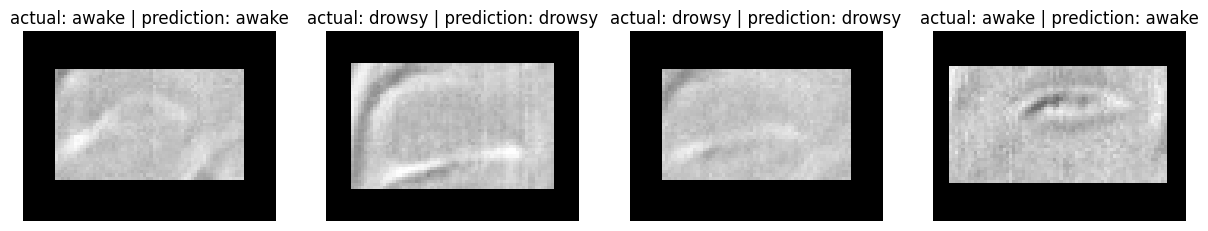

In [23]:
#take random 3 imgs for prediction example
img, label = next(iter(val_dataloader))

random_indices= random.sample(range(8), 4)
imgs = []
labels = []

for idx in random_indices:
  imgs.append(img[idx])
  if label[idx].item() == 0:
    labels.append("awake")
  else:
    labels.append("drowsy")

fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # 1 row, 3 columns

# Iterate through each subplot and plot the image
prediction = ""
for i, ax in enumerate(axes):

    #model prediction
    img = imgs[i]
    img = img.unsqueeze(dim=0)
    img = img.to(device)

    pred = model(img)

    output = torch.sigmoid(pred)

    if output >= 0.5:
        prediction = "drowsy"
    else:
        prediction = "awake"
    img_transposed = np.transpose(imgs[i], (1, 2, 0))
    ax.imshow(img_transposed)  # Plot the image on the subplot
    ax.set_title(f"actual: {labels[i]} | prediction: {prediction}") 
    ax.axis("off")

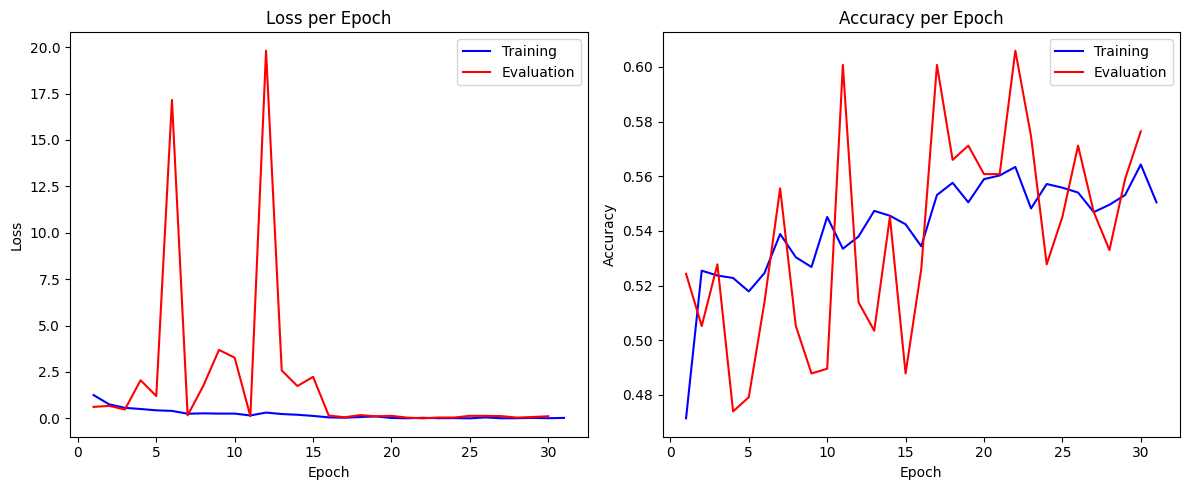

In [20]:
#plot metrics
train_csv = "training_metrics_test.csv"
eval_csv = "eval_metrics_test.csv"
plot_metrics(train_csv, eval_csv)